---
# Esercitazione 3
---
## Esercizio 3.1 - Plain vanilla option pricing
In questa esercitazione si vuole stimare tramite simulazione **Monte Carlo** il prezzo di un'opzione europea tipo $\textit{call}$, $C[S(t),t]$, e tipo $\textit{put}$, $P[S(t),t]$, al tempo $t=0$. Un'opzione è un contratto finanziario che dà al detentore il diritto, ma non l'obbligo, di comprare (opzione call) o vendere (opzione put) un'attività sottostante a un prezzo predeterminato (strike price $K$) entro una data specifica (data di scadenza $T$). 

### Esempio pratico sulle opzioni call
Un'azione al tempo presente $t=0$ vale $S_0=100$ e un'opzione tipo call costa $C=15$. Questo è il costo per acquistare il diritto di comprare quell'azione in futuro, al tempo $T=1$ (ad esempio a distanza di $1$ anno), al prezzo $K=100$ concordato. Acquisterò l'opzione se scommetto sull'incremento del valore dell'azione, in modo che in futuro io possa acquistarla poi al prezzo concordato, inferiore a quello di mercato. Supponendo che in futuro $S(T)=120$, eserciterò dunque il diritto dell'opzione e potrò acquistarla a $K=100$, per poi rivenderla a mercato a $120$, ottenendo dunque un profitto netto di $5$ (togliendo i costi dell'opzione). Nel nostro caso si calcola / stima una previsione sul prezzo delle opzioni call e put, ovvero all'atto pratico vado ad acquistare l'opzione (ovviamente a $t=0$, dunque la previsione del prezzo va fatta per $t=0$) se la previsione teorica del suo costo è superiore a quella di mercato (ovvero sottovalutata).
Per le opzioni put il ragionamento è opposto, in quanto il diritto riguarda la vendita di un'asset sottostante.

Per questo tipo di opzioni eiste soluzione analitica alla previsione dei prezzi: l'equazione di Black-Scholes. Essa è fondamentale nella finanza matematica e viene utilizzata da trader e analisti finanziari per determinare il prezzo equo delle opzioni, aiutando a valutare se sono sottovalutate o sopravvalutate rispetto al mercato.

I parametri utilizzati sono i seguenti:
- prezzo dell'asset al tempo $t=0$: $S(0)=100$
- tempo di scadenza del contratto (delivery date): $T=1$
- prezzo concordato / di esercizio (strike price): $K=100$
- tasso d'interesse, rendimento teorico di un investimento senza rischi (risk-free interest rate): $r=0.1$
- volatilità, costante e indipendente: $\sigma=0.25$

Per quanto riguarda l'evoluzione temporale del prezzo di un asset, è ragionevole ipotizzare che esso segua un moto browniano geometrico (GBM). La simulazione viene dunque svolta utilizzando due metodi:
1. Campionamento **diretto** del prezzo finale dell'asset sottostante l'azione $S(T)$, considerando una $GBM(drift=r,volatility=\sigma^2)$
2. Campionamento a tempi discreti del percorso della $GBM(r,\sigma^2)$ per il prezzo dell'asset, dividendo $[0,T]$ in $10^2$ intervalli: $S(0)$, $S(t_1)$, $S(t_2)$, ... fino a $S(t_{100}=T=1)$

L'equazione ricorsiva utilizzata nel secondo punto è:

$$S(t_{i+1}) = S(t_i) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)(t_{i+1}-t_i)
+\sigma Z_{i+1}\sqrt{t_{i+1}-t_i}\right]$$

con $t_1 < t_2 < … < t_n$ e $Z_i \sim \mathcal{N}(0,1)$, ovvero distribuita normalmente. $\\$
Per il primo caso basta invece utilizzare $t_k=0 \quad\forall k \neq 1$ e $t_1=T$ e dunque una sola valutazione.

Una volta ottenuto il prezzo finale dell'asset, per ricavare il prezzo teorico dell'opzione tipo call al tempo presemte $t=0$ si procede nel modo seguente:

$$C = \exp(-rT) \cdot \text{max}[0, S(T)-K]$$

questo rappresenta il costo atteso per ottenere il diritto di acquistare l'azione al tempo $t=T$ al prezzo $K$, ovvero il prezzo della call. Globalmente, è dunque necessario calcolare il profitto lordo per azione ($S(T)-K$) al tempo presente, sottraendo il prezzo concordato $K$ al prezzo previsto al tempo $T$, per poi valutare il risultato al tempo presente considerando l'incremento da tasso d'interesse fisso $r$ (tramite moltiplicazione per l'esponenziale). Si considera il massimo tra $0$ e $S(T)-K$ in quanto se quest'ultimo fosse negativo o nullo (e quindi $S(T) \leq K$) l'azione non verrebbe acquistata a $t=T$ in quanto sconveniente o inutile. Il profitto netto sarà uguale al profitto lordo a cui sottrarre il costo dell'opzione call esercitata. Come detto in precedenza, l'opzione verrà acquistata se questa previsione teorica sul suo prezzo al tempo presente è superiore a quanto è in realtà (in modo da ridurre il costo fisso e aumentare i margini di profitto).

Il caso di opzione put è esattamente invertito.

In entrambi i casi vengono svolte $10^5$ simulazioni. I risultati di $C$ per ogni simulazione sono analizzati tramite metodo della divisione in blocchi ($N=100$ blocchi) e confrontati con il valore teorico calcolato analiticamente grazie all'equazione di Black-Scholes. Entrambi questi valori di prezzo call e put sono calcolati qui sotto.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf
from numpy import exp
from numpy.lib.scimath import log, sqrt

# carico i risultati dei 4 casi
# call e put price con i loro errori nel caso diretto
dir_call, err_dir_call, dir_put, err_dir_put = np.loadtxt("./CALL_PUT_direct.txt", unpack= True, usecols=(0,1,2,3), skiprows=1)
# call e put price con i loro errori nel caso discreto
dis_call, err_dis_call, dis_put, err_dis_put = np.loadtxt("./CALL_PUT_discrete.txt", unpack= True, usecols=(0,1,2,3), skiprows=1)
 
# data
S0 = 100.
K = 100.
T = 1.
r = 0.1
sigma = 0.25
t=0

def N(x):
    return 0.5 * (1. + erf(x / sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * sqrt(T)) * (log(S0 / K) + (r + (sigma**2) / 2.) * T)
    d2 = d1 - sigma * sqrt(T)
    C = S0 * N(d1) - K * exp(-r * T) * N(d2)
    P = S0 *(N(d1) - 1.) - K * exp(-r * T) * (N(d2)-1.)
    return C, P

if __name__ == "__main__":
    teo_call, teo_put = black_scholes(S0, K, T, r, sigma)

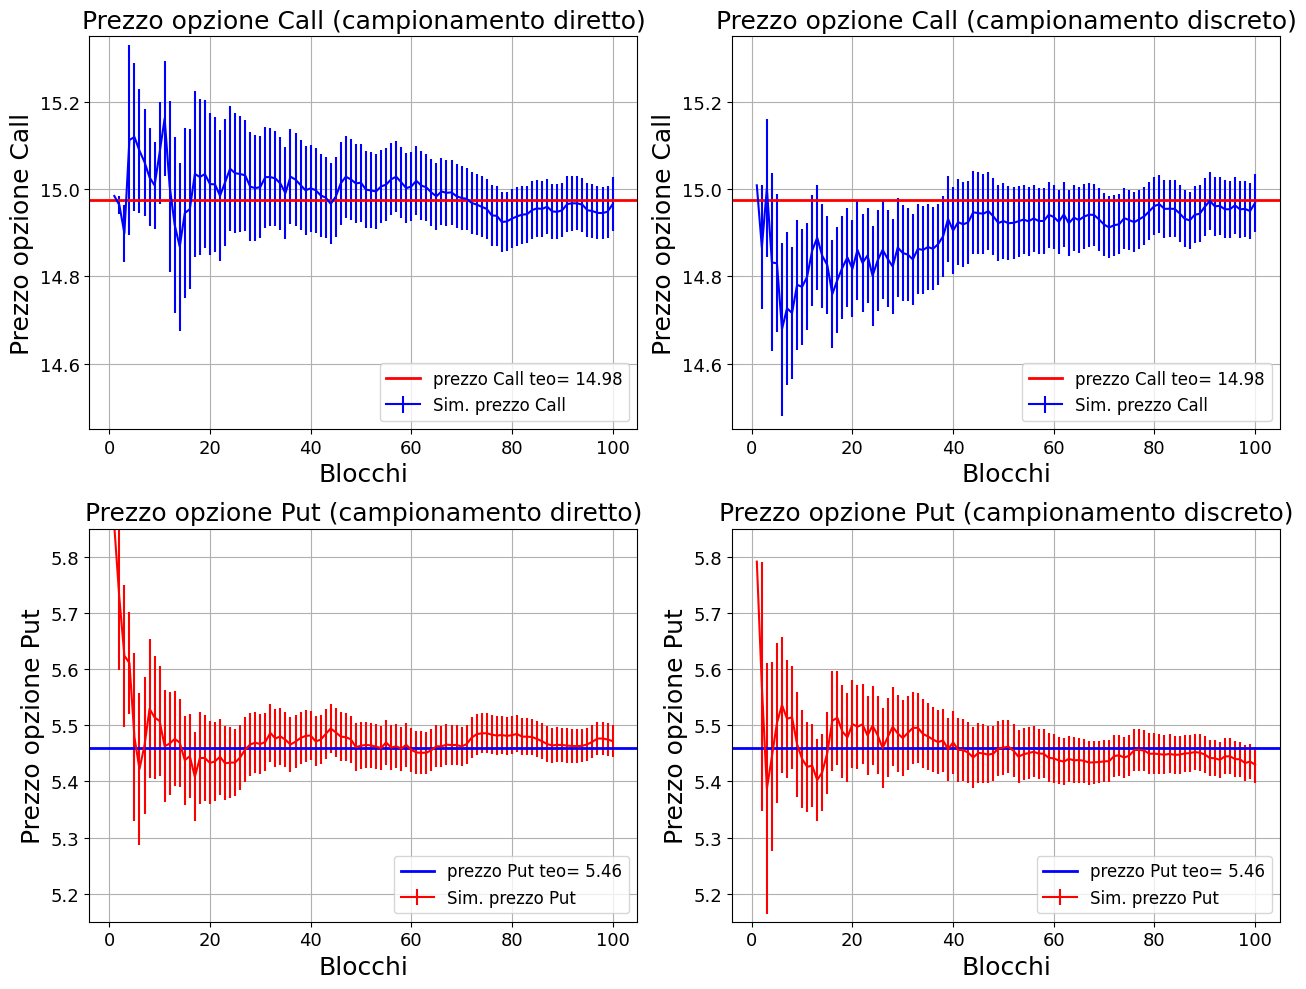

Valor medio prezzo opzione Call (campionamento diretto):  14.965 +\- 0.062
Livello di confidenza con il valore atteso:  0.17 sigma


Valor medio prezzo opzione Call (campionamento discreto):  14.968 +\- 0.066
Livello di confidenza con il valore atteso:  0.11 sigma

 ---------------------
Valor medio prezzo opzione Put (campionamento diretto):  5.472 +\- 0.029
Livello di confidenza con il valore atteso:  0.42 sigma


Valor medio prezzo opzione Put (campionamento discreto):  5.43 +\- 0.032
Livello di confidenza con il valore atteso:  0.93 sigma


In [3]:
N_blocks = len(dir_call) # numero blocchi

# x del grafico, numero di lanci totali incrementando ogni volta il numero di blocchi
x = np.arange(1, N_blocks+1)     # numero blocchi

plt.figure(figsize=(13,10))

##################################
# Grafico prezzo Call caso dicreto
plt.subplot(2,2,1)

plt.title(r"Prezzo opzione Call (campionamento diretto)", fontsize=18)

plt.ylim(14.45, 15.35)
plt.errorbar(x, dir_call, yerr=err_dir_call, label = "Sim. prezzo Call", color = 'blue') #plotto la media cumulativa con errore del prezzo di Call

plt.xlabel(r"Blocchi", fontsize=18)
plt.ylabel(r"Prezzo opzione Call", fontsize=18)

plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

plt.axhline(y=teo_call, xmin=0, xmax=1, label=r'prezzo Call teo= %.2f' %(teo_call), lw = 2, color = 'red')

plt.legend(loc='lower right', prop={'size': 12})

plt.grid(True)
plt.tight_layout() # per ridurre lo spazio bianco intorno

######################################
# Plot prezzo Put caso diretto

plt.subplot(2,2,3)

plt.title(r"Prezzo opzione Put (campionamento diretto)", fontsize=18)

plt.ylim(5.15, 5.85)
plt.errorbar(x, dir_put, yerr=err_dir_put, label = "Sim. prezzo Put", color = 'red') #plotto la media cumulativa con errore del prezzo di Call

plt.xlabel(r"Blocchi", fontsize=18)
plt.ylabel(r"Prezzo opzione Put", fontsize=18)

plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

plt.axhline(y=teo_put, xmin=0, xmax=1, label=r'prezzo Put teo= %.2f' %(teo_put), lw = 2, color = 'blue')

plt.legend(loc='lower right', prop={'size': 12})

plt.grid(True)
plt.tight_layout() # per ridurre lo spazio bianco intorno

#####################################
# Grafico prezzo Call caso discreto
plt.subplot(2,2,2)

plt.title(r"Prezzo opzione Call (campionamento discreto)", fontsize=18)

plt.ylim(14.45, 15.35)
plt.errorbar(x, dis_call, yerr=err_dis_call, label = "Sim. prezzo Call", color = 'blue') #plotto la media cumulativa con errore del prezzo di Call

plt.xlabel(r"Blocchi", fontsize=18)
plt.ylabel(r"Prezzo opzione Call", fontsize=18)

plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

plt.axhline(y=teo_call, xmin=0, xmax=1, label=r'prezzo Call teo= %.2f' %(teo_call), lw = 2, color = 'red')

plt.legend(loc='lower right', prop={'size': 12})

plt.grid(True)
plt.tight_layout() # per ridurre lo spazio bianco intorno

######################################
# Plot prezzo Put caso discreto

plt.subplot(2,2,4)

plt.title(r"Prezzo opzione Put (campionamento discreto)", fontsize=18)

plt.ylim(5.15, 5.85)
plt.errorbar(x, dis_put, yerr=err_dis_put, label = "Sim. prezzo Put", color = 'red') #plotto la media cumulativa con errore del prezzo di Call

plt.xlabel(r"Blocchi", fontsize=18)
plt.ylabel(r"Prezzo opzione Put", fontsize=18)

plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

plt.axhline(y=teo_put, xmin=0, xmax=1, label=r'prezzo Put teo= %.2f' %(teo_put), lw = 2, color = 'blue')

plt.legend(loc='lower right', prop={'size': 12})

plt.grid(True)
plt.tight_layout() # per ridurre lo spazio bianco intorno

plt.show()

print("Valor medio prezzo opzione Call (campionamento diretto): ", round(dir_call[-1],3), "+\-", round(err_dir_call[-1],3))
print("Livello di confidenza con il valore atteso: ",np.abs(round((dir_call[-1] - teo_call)/err_dir_call[-1],2)), "sigma")
print("\n")

print("Valor medio prezzo opzione Call (campionamento discreto): ", round(dis_call[-1],3), "+\-", round(err_dis_call[-1],3))
print("Livello di confidenza con il valore atteso: ",np.abs(round((dis_call[-1] - teo_call)/err_dis_call[-1],2)), "sigma")
print("\n ---------------------")

print("Valor medio prezzo opzione Put (campionamento diretto): ", round(dir_put[-1],3), "+\-", round(err_dir_put[-1],4))
print("Livello di confidenza con il valore atteso: ", np.abs(round((dir_put[-1] - teo_put)/err_dir_put[-1],2)), "sigma")
print("\n")

print("Valor medio prezzo opzione Put (campionamento discreto): ", round(dis_put[-1],3), "+\-", round(err_dis_put[-1],4))
print("Livello di confidenza con il valore atteso: ", np.abs(round((dis_put[-1] - teo_put)/err_dis_put[-1],2)), "sigma")

Come è possibile notare, il metodo Monte Carlo utilizzato per prevedere i costi delle azioni rispecchia quanto teoricamente calcolato. Nei due metodi utilizzati non vi è una preferenza significativa.